
# EVAT — Congestion Prediction (3‑Hour Arrivals, Poisson LSTM + M/M/c)

This notebook is tailored to your dataset's low arrival rates. It uses **3‑hour bins** for arrivals,
which we selected based on sparsity tests and Poisson zero‑probability analysis.  
Pipeline:
1. Build per‑station **arrivals time series at 180‑minute bins** from `pre-processed-dataset.csv`.
2. Feature engineering (calendar, lags/rolls) on the 3‑hour grid.
3. Time‑based train/val/test split (per station → concatenate).
4. Global **Poisson LSTM** (softplus output) for arrival counts.
5. Evaluate (MAE, RMSE, MAPE) and save predictions.
6. **M/M/c** queue metrics (expected wait mins, queue length).
7. Minimal **Streamlit** dashboard.

> Place the CSVs in the working directory: `pre-processed-dataset.csv`.


In [38]:

# ---- Imports & Config ----
import os, json, math, warnings
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

DATA_DIR = Path(".")
SESS_CSV = DATA_DIR / "pre-processed-dataset.csv"    # session‑level data (has created, ended, stationId, chargeTimeHrs)
BIN_MIN  = 180                                       # 3 hours
SEQ      = 16                                        # 48 hours of history on the 3h grid


In [39]:

# ---- Load session data & sanity checks ----
sess = pd.read_csv(SESS_CSV, parse_dates=["created","ended"], infer_datetime_format=True)
sess = sess.dropna(subset=["created","ended"])
sess = sess[sess["created"] <= sess["ended"]].copy()
sess = sess.sort_values(["stationId","created"]).reset_index(drop=True)

print("Stations:", sess["stationId"].nunique())
print(sess.groupby("stationId")["sessionId"].count().sort_values(ascending=False).head())


Stations: 4
stationId
369001    334
474204    213
955429    190
228137    104
Name: sessionId, dtype: int64


In [40]:

# ---- Build per‑station arrivals on aligned 3h grid ----
def build_arrivals(df, bin_minutes=180):
    out = []
    for sid, g in df.groupby("stationId"):
        start = g["created"].min().floor(f"{bin_minutes}T")
        end   = g["ended"].max().ceil(f"{bin_minutes}T")
        idx   = pd.date_range(start, end, freq=f"{bin_minutes}T")
        cnt   = g.groupby(pd.Grouper(key="created", freq=f"{bin_minutes}T")).size()
        cnt   = cnt.reindex(idx, fill_value=0).astype(int)
        out.append(pd.DataFrame({"stationId": sid, "timestamp": idx, "arrivals": cnt.values}))
    ts = pd.concat(out, ignore_index=True)
    ts = ts.sort_values(["stationId","timestamp"]).reset_index(drop=True)
    return ts

ts3 = build_arrivals(sess, BIN_MIN)
print(ts3.head())
ts3.to_csv("arrivals_timeseries_3h.csv", index=False)
print("Saved arrivals_timeseries_3h.csv")


   stationId           timestamp  arrivals
0     228137 2015-03-17 12:00:00         1
1     228137 2015-03-17 15:00:00         0
2     228137 2015-03-17 18:00:00         0
3     228137 2015-03-17 21:00:00         0
4     228137 2015-03-18 00:00:00         0
Saved arrivals_timeseries_3h.csv


In [41]:

# ---- Feature engineering on 3h grid ----
ts = ts3.copy()
ts["hour"]       = ts["timestamp"].dt.hour
ts["dayofweek"]  = ts["timestamp"].dt.dayofweek
ts["is_weekend"] = ts["dayofweek"].isin([5,6]).astype(int)

# Cyclical time features (3h grid has 8 bins/day)
ts["hod"] = (ts["timestamp"].dt.hour // 3).astype(int)  # 0..7
ts["hod_sin"] = np.sin(2*np.pi*ts["hod"]/8)
ts["hod_cos"] = np.cos(2*np.pi*ts["hod"]/8)

# Include in feature list
feature_cols += ["hod_sin", "hod_cos"]

def add_lags_rolls(df, col="arrivals", lags=(1,2,4), rolls=(4,8)):
    for L in lags:
        df[f"{col}_lag{L}"] = df.groupby("stationId")[col].shift(L)
    for W in rolls:
        df[f"{col}_ma{W}"] = df.groupby("stationId")[col].shift(1).rolling(W).mean()
    return df

ts = add_lags_rolls(ts)
ts_fe = ts.dropna().reset_index(drop=True)

feature_cols = [
    "hour","dayofweek","is_weekend",
    "arrivals_lag1","arrivals_lag2","arrivals_lag4",
    "arrivals_ma4","arrivals_ma8",
]
target_col = "arrivals"


In [42]:

# ---- Time-based split (70/15/15) per station ----
def time_split_station(df, train=0.70, val=0.15):
    n = len(df)
    i1 = int(n*train); i2 = int(n*(train+val))
    return df.iloc[:i1], df.iloc[i1:i2], df.iloc[i2:]

train_list, val_list, test_list = [], [], []
for sid, g in ts_fe.groupby("stationId", sort=True):
    g = g.sort_values("timestamp")
    tr, va, te = time_split_station(g)
    train_list.append(tr); val_list.append(va); test_list.append(te)

train_df = pd.concat(train_list).reset_index(drop=True)
val_df   = pd.concat(val_list).reset_index(drop=True)
test_df  = pd.concat(test_list).reset_index(drop=True)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
X_val   = scaler.transform(val_df[feature_cols])
X_test  = scaler.transform(test_df[feature_cols])

y_train = train_df[target_col].values.astype(float)
y_val   = val_df[target_col].values.astype(float)
y_test  = test_df[target_col].values.astype(float)

# Build sequences
def lengths_per_station(df): return df.groupby("stationId").size().values.tolist()

def to_sequences(X, y, groups, seq_len=SEQ):
    Xs, ys = [], []
    start = 0
    for g in groups:
        end = start + g
        Xg, yg = X[start:end], y[start:end]
        for i in range(seq_len, len(Xg)):
            Xs.append(Xg[i-seq_len:i]); ys.append(yg[i])
        start = end
    return np.array(Xs), np.array(ys)

Xtr, ytr = to_sequences(X_train, y_train, lengths_per_station(train_df), SEQ)
Xva, yva = to_sequences(X_val,   y_val,   lengths_per_station(val_df),   SEQ)
Xte, yte = to_sequences(X_test,  y_test,  lengths_per_station(test_df),  SEQ)

Xtr.shape, Xva.shape, Xte.shape


((4272, 16, 8), (865, 16, 8), (867, 16, 8))

In [43]:

# ---- Baselines ----
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def _rmse(y_true, y_pred):
    # Compatible RMSE for all sklearn versions
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def eval_preds(y_true, y_pred, name):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = _rmse(y_true, y_pred)
    mape = (np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100.0)
    print(f"{name:>14} | MAE={mae:.3f}  RMSE={rmse:.3f}  MAPE={mape:.1f}%")

def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = _rmse(y_true, y_pred)
    mape = (np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100.0)
    return {"MAE": float(mae), "RMSE": float(rmse), "MAPE%": float(mape)}


# Naive baseline on test series (per station, then concat)
test_series = test_df.sort_values(["stationId","timestamp"])[target_col].values
naive_pred = test_series[:-1]
naive_true = test_series[1:]
eval_preds(naive_true, naive_pred, "Naive")


         Naive | MAE=0.252  RMSE=0.541  MAPE=1247311839.9%


Epoch 1/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.8263 - mae: 0.5325 - val_loss: 1.4786 - val_mae: 0.4187
Epoch 2/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6507 - mae: 0.3652 - val_loss: 1.3793 - val_mae: 0.2921
Epoch 3/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5575 - mae: 0.2877 - val_loss: 1.3297 - val_mae: 0.3097
Epoch 4/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5418 - mae: 0.2851 - val_loss: 1.3256 - val_mae: 0.3295
Epoch 5/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5331 - mae: 0.2882 - val_loss: 1.3337 - val_mae: 0.2839
Epoch 6/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5217 - mae: 0.2758 - val_loss: 1.3526 - val_mae: 0.2820
Epoch 7/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5257 - mae: 0.2789 - val_loss: 1.2964 - val_mae: 0.2765
Epoch 8/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5079 - mae: 0.2576 - val_loss: 1.3164 - val_mae: 0.3151
Epoch 9/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5121 - mae: 

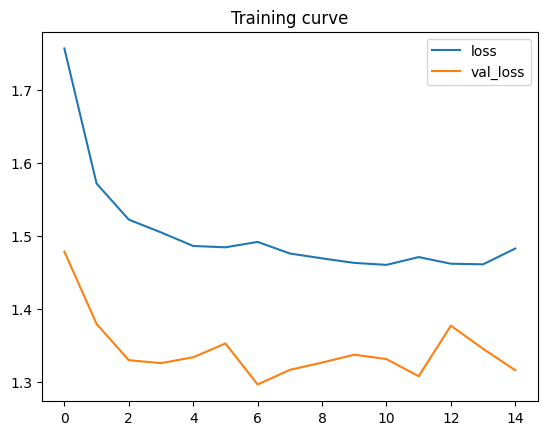

In [44]:

# ---- Poisson LSTM ----
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(Xtr.shape[1], Xtr.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(1, activation="softplus")
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.Poisson(),
              metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")])

# Up-weight non-zero bins so spikes matter more
alpha = 8.0  # try 6–12; larger = more focus on spikes
w_train = 1.0 + alpha * (ytr > 0).astype(float)
w_val   = 1.0 + alpha * (yva > 0).astype(float)

cb = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)]

hist = model.fit(
    Xtr, ytr,
    validation_data=(Xva, yva, w_val),  # Keras supports val_sample_weight as 3rd item
    sample_weight=w_train,
    epochs=60,
    batch_size=64,
    callbacks=cb,
    verbose=1
)


import pandas as pd, matplotlib.pyplot as plt
pd.DataFrame(hist.history)[["loss","val_loss"]].plot(title="Training curve"); plt.show()


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Test metrics: {'MAE': 0.29795174154574094, 'RMSE': 0.46689847408609386, 'SMAPE%': 86.64244548451474, 'PoissonDeviance': 0.5521117328178837}


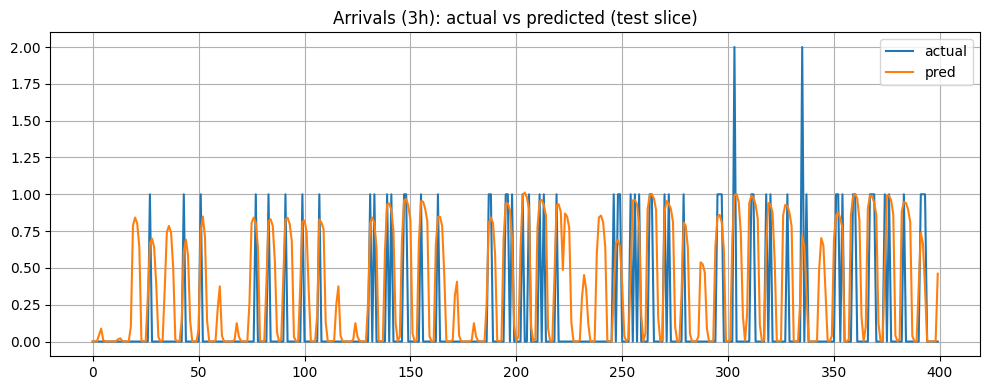

Saved: predictions_test_arrivals_3h.csv, evaluation_metrics_3h.json


In [45]:
# ---- Evaluate & save predictions ----
import numpy as np, json, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

yhat_test = model.predict(Xte).reshape(-1)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def smape(y_true, y_pred):
    denom = np.abs(y_true) + np.abs(y_pred)
    denom = np.where(denom == 0, 1.0, denom)  # avoid 0/0
    return float(100.0 * np.mean(np.abs(y_true - y_pred) / denom))

def mean_poisson_deviance(y_true, y_pred, eps=1e-9):
    # Expected deviance for Poisson counts (aligns with your Poisson loss)
    y_pred = np.clip(y_pred, eps, None)
    # y*log(y/lambda) - (y - lambda); when y=0, term -> +lambda
    term = np.where(
        y_true > 0,
        y_true * np.log(y_true / y_pred) - (y_true - y_pred),
        y_pred  # y=0 => deviance contribution = lambda
    )
    return float(2.0 * np.mean(term))

def metrics(y_true, y_pred):
    return {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": rmse(y_true, y_pred),
        "SMAPE%": smape(y_true, y_pred),
        "PoissonDeviance": mean_poisson_deviance(y_true, y_pred),
    }

m = metrics(yte, yhat_test)
print("Test metrics:", m)

def rebuild_index_groupwise(df, seq_len=SEQ):
    """
    Align targets to sequences: for each station, drop the first `seq_len` rows,
    because the first target is only available after seq_len steps of history.
    """
    parts = []
    for sid, g in df.groupby("stationId", sort=True):
        g = g.sort_values("timestamp")
        if len(g) > seq_len:
            parts.append(g.iloc[seq_len:][["stationId","timestamp","arrivals"]])
    if len(parts) == 0:
        return pd.DataFrame(columns=["stationId","timestamp","arrivals"])
    return pd.concat(parts, ignore_index=True)

test_index = rebuild_index_groupwise(test_df, SEQ)
assert len(test_index) == len(yhat_test), f"Length mismatch: {len(test_index)} vs {len(yhat_test)}"

pred_df = test_index.copy()
pred_df["pred_arrivals_3h"] = yhat_test
pred_df.to_csv("predictions_test_arrivals_3h.csv", index=False)

with open("evaluation_metrics_3h.json","w") as f:
    json.dump(m, f, indent=2)

# quick plot
nplot = min(400, len(yte))
plt.figure(figsize=(10,4))
plt.plot(yte[:nplot], label="actual")
plt.plot(yhat_test[:nplot], label="pred")
plt.legend()
plt.title("Arrivals (3h): actual vs predicted (test slice)")
plt.grid(True)
plt.tight_layout()
plt.show()

print("Saved: predictions_test_arrivals_3h.csv, evaluation_metrics_3h.json")


In [46]:
# ---- Queueing theory (M/M/c) — robust μ and data‑driven c ----
import numpy as np
import pandas as pd
from math import factorial

# 1) Robust service rate μ (sessions/hour) per station from session durations
sess["chargeTimeHrs"] = pd.to_numeric(sess["chargeTimeHrs"], errors="coerce")
mu_per_station = {}
for sid, g in sess.groupby("stationId"):
    h = pd.to_numeric(g["chargeTimeHrs"], errors="coerce").dropna()
    h = h[h > 0]
    if len(h) == 0:
        mu_per_station[int(sid)] = np.nan
        continue
    inv = 1.0 / h  # service rate samples (per hour)
    # Trim extremes to reduce outlier influence
    q1, q9 = inv.quantile([0.10, 0.90])
    mu_per_station[int(sid)] = float(inv[(inv >= q1) & (inv <= q9)].mean())

# 2) Estimate number of parallel chargers c via max concurrent sessions
#    (sweep-line over session start/end times)
def max_concurrency_for_station(df: pd.DataFrame) -> int:
    events = []
    for _, r in df.dropna(subset=["created","ended"]).iterrows():
        events.append((r["created"], +1))
        events.append((r["ended"],   -1))
    if not events:
        return 1
    events.sort()
    cur = mmax = 0
    for _, d in events:
        cur += d
        mmax = max(mmax, cur)
    return max(1, int(mmax))

c_per_station = {int(sid): max_concurrency_for_station(g) for sid, g in sess.groupby("stationId")}

print("Estimated chargers c per station:", c_per_station)
print("Estimated μ per station:", {k: (None if pd.isna(v) else round(v, 3)) for k, v in mu_per_station.items()})

# 3) Erlang‑C helpers

def erlang_c_wait_time(lam_hour: float, mu_hour: float, c: int):
    """Return (Wq_hours, Lq, rho).
    lam_hour: arrival rate per hour
    mu_hour: service rate per server per hour
    c: number of identical servers
    """
    if c <= 0 or mu_hour is None or np.isnan(mu_hour) or mu_hour <= 0:
        return np.nan, np.nan, np.nan
    if lam_hour <= 0:
        return 0.0, 0.0, 0.0
    rho = lam_hour / (c * mu_hour)
    if rho >= 1:  # unstable system
        return float("inf"), float("inf"), float(rho)
    a = lam_hour / mu_hour
    # P0
    sum_terms = 0.0
    for n in range(c):
        # (a^n) / n!
        term = 1.0
        for k in range(1, n + 1):
            term *= a / k
        sum_terms += term
    # last term for Erlang-C
    term_c = 1.0
    for k in range(1, c + 1):
        term_c *= a / k
    last_term = term_c / (1.0 - rho)
    P0 = 1.0 / (sum_terms + last_term)
    # Lq and Wq
    Lq = (P0 * term_c * rho) / ((1.0 - rho) ** 2)
    Wq_hours = Lq / lam_hour
    return float(Wq_hours), float(Lq), float(rho)

# 4) Apply to predictions (pred_df expected from previous cell)
rows = []
for _, row in pred_df.iterrows():
    sid = int(row["stationId"])
    lam_hour = max(0.0, float(row["pred_arrivals_3h"])) / 3.0  # convert 3h count to hourly rate
    mu = mu_per_station.get(sid, np.nan)
    c = int(c_per_station.get(sid, 1))
    Wq_h, Lq, rho = erlang_c_wait_time(lam_hour, mu, c)
    rows.append({
        "c": c,
        "mu": mu,
        "lambda_hour": lam_hour,
        "rho": rho,
        "expected_wait_mins": (np.nan if pd.isna(Wq_h) else Wq_h * 60.0),
        "expected_queue_len": Lq,
    })

q_df = pd.DataFrame(rows)
final_df = pd.concat([pred_df.reset_index(drop=True), q_df], axis=1)
final_df.to_csv("predictions_3h_with_wait_times.csv", index=False)
print("Saved: predictions_3h_with_wait_times.csv")
final_df.head()


Estimated chargers c per station: {228137: 1, 369001: 1, 474204: 2, 955429: 2}
Estimated μ per station: {228137: 0.396, 369001: 0.419, 474204: 0.381, 955429: 0.464}
Saved: predictions_3h_with_wait_times.csv


,stationId,timestamp,arrivals,pred_arrivals_3h,c,mu,lambda_hour,rho,expected_wait_mins,expected_queue_len
0,228137,2015-09-05 00:00:00,0,0.000360,1,0.396051,0.000120,0.000303,0.045896,9.175120e-08
1,228137,2015-09-05 03:00:00,0,0.000467,1,0.396051,0.000156,0.000393,0.059606,1.547420e-07
2,228137,2015-09-05 06:00:00,0,0.002235,1,0.396051,0.000745,0.001881,0.285528,3.545505e-06
3,228137,2015-09-05 09:00:00,0,0.044261,1,0.396051,0.014754,0.037252,5.861874,1.441402e-03
4,228137,2015-09-05 12:00:00,0,0.087706,1,0.396051,0.029235,0.073817,12.074265,5.883253e-03



## Minimal Streamlit app
Run:
```bash
streamlit run streamlit_app_3h.py
```


In [47]:
%%writefile streamlit_app_3h.py
import math
import numpy as np
import pandas as pd
import streamlit as st

st.set_page_config(page_title="EVAT Congestion (3h)", layout="wide")
st.title("EVAT — Congestion (3‑hour arrivals)")

# ---- Load predictions with queueing inputs ----
path = "predictions_3h_with_wait_times.csv"
df = pd.read_csv(path, parse_dates=["timestamp"])

# Sanity: ensure inputs exist (lambda_hour, mu, c). If missing, derive lambda_hour from 3h counts.
if "lambda_hour" not in df.columns and "pred_arrivals_3h" in df.columns:
    df["lambda_hour"] = np.clip(df["pred_arrivals_3h"], 0, None) / 3.0

# ---- Sidebar filters & what‑if controls ----
st.sidebar.header("Filters")
stations = sorted(df["stationId"].unique().tolist())
sid = st.sidebar.selectbox("Station", stations)

st.sidebar.header("What‑if settings")
c_multiplier  = st.sidebar.slider("Charger multiplier (c×)", 0.5, 3.0, 1.0, 0.1)
mu_multiplier = st.sidebar.slider("Service speed multiplier (μ×)", 0.5, 2.0, 1.0, 0.1)

# ---- Erlang‑C (same math used in the notebook) ----
def erlang_c_wait_time(lam_hour: float, mu_hour: float, c: int):
    """Return (Wq_hours, Lq, rho). Uses numerically safe products."""
    if c <= 0 or mu_hour is None or np.isnan(mu_hour) or mu_hour <= 0:
        return np.nan, np.nan, np.nan
    if lam_hour <= 0:
        return 0.0, 0.0, 0.0
    rho = lam_hour / (c * mu_hour)
    if rho >= 1.0:
        return float("inf"), float("inf"), float(rho)

    a = lam_hour / mu_hour  # traffic intensity in Erlang
    # Compute sum_{n=0}^{c-1} a^n / n! safely
    sum_terms = 0.0
    term = 1.0  # a^0 / 0! = 1
    sum_terms += term
    for n in range(1, c):
        term *= a / n
        sum_terms += term
    # term_c = a^c / c!
    term_c = term * (a / c) if c > 0 else 0.0

    P0 = 1.0 / (sum_terms + (term_c / (1.0 - rho)))
    Lq = (P0 * term_c * rho) / ((1.0 - rho) ** 2)
    Wq_hours = Lq / lam_hour
    return float(Wq_hours), float(Lq), float(rho)

# ---- Slice station & recompute what‑if wait times ----
d = df[df["stationId"] == sid].sort_values("timestamp").copy()

# Apply multipliers (round c to nearest int and minimum 1)
if "c" in d.columns:
    d["c_adj"] = np.maximum(1, np.round(d["c"] * c_multiplier).astype(int))
else:
    d["c_adj"] = 1  # fallback

if "mu" in d.columns:
    d["mu_adj"] = d["mu"] * mu_multiplier
else:
    d["mu_adj"] = np.nan  # fallback; will yield NaN waits

# Recompute wait times row-by-row
Wq_mins_adj = []
rho_adj = []
for lam, mu, cc in zip(d.get("lambda_hour", pd.Series([np.nan]*len(d))), d["mu_adj"], d["c_adj"]):
    Wq_h, Lq, rho = erlang_c_wait_time(float(lam) if pd.notnull(lam) else 0.0,
                                       float(mu) if pd.notnull(mu) else np.nan,
                                       int(cc))
    # Cap inf for display
    if np.isinf(Wq_h):
        Wq_mins_adj.append(np.nan)  # we'll format as "unstable" in metric
    else:
        Wq_mins_adj.append(Wq_h * 60.0)
    rho_adj.append(rho)

d["expected_wait_mins_adj"] = Wq_mins_adj
d["rho_adj"] = rho_adj

# ---- Layout ----
col1, col2 = st.columns(2)

with col1:
    st.write("### Arrivals (actual vs predicted, 3h bins)")
    # Some rows (earliest) may not have 'arrivals' aligned; fill with 0 for plotting
    to_plot = d.set_index("timestamp")[["pred_arrivals_3h"]].copy()
    if "arrivals" in d.columns:
        to_plot["arrivals"] = d.set_index("timestamp")["arrivals"]
        to_plot = to_plot[["arrivals", "pred_arrivals_3h"]]
    st.line_chart(to_plot)

with col2:
    st.write("### Expected wait time (minutes)")
    # Prefer adjusted waits if μ and c are present; fall back to original if not
    if "expected_wait_mins" in d.columns and d["mu"].notna().any() and d["c"].notna().any():
        st.caption("Showing **what‑if** wait times with sliders (recomputed via Erlang‑C).")
        st.line_chart(d.set_index("timestamp")[["expected_wait_mins_adj"]])
    else:
        st.caption("Base wait times (no μ/c info available to recompute).")
        st.line_chart(d.set_index("timestamp")[["expected_wait_mins"]])

# ---- KPIs ----
latest = d.iloc[-1]
# Wait metric formatting
wait_val = latest["expected_wait_mins_adj"]
if pd.isna(wait_val) and "expected_wait_mins" in d.columns:
    wait_val = latest.get("expected_wait_mins", np.nan)

wait_text = "N/A"
if pd.notnull(wait_val):
    wait_text = f"{wait_val:.1f}"
elif pd.notnull(latest.get("rho_adj", np.nan)) and latest["rho_adj"] >= 1.0:
    wait_text = "Unstable (ρ≥1)"

st.metric("Latest predicted wait (mins)", wait_text)

qlen = latest.get("expected_queue_len", np.nan)
st.metric("Latest predicted queue length", f"{qlen:.2f}" if pd.notnull(qlen) else "N/A")

# Utilization readout (helps debug stability)
rho_disp = latest.get("rho_adj", np.nan)
st.metric("Utilization ρ (latest)", f"{rho_disp:.2f}" if pd.notnull(rho_disp) else "N/A")

st.caption("Tip: increase **c×** or **μ×** if the system becomes unstable (ρ≥1).")

Writing streamlit_app_3h.py
